# Preparação do ambiente

## Bibliotecas

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import load

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline

## Constantes e funções auxiliares

In [13]:
FILE_MARKETPLACES = '../datasets/label_issues/20240423/results/marketplaces.parquet'
FILE_SUPERVISAO_MERCADO = '../datasets/supervisao_mercado/supervisao_mercado.xlsx'
FILE_MODEL_CLF3 = '../experimentos/assets/exp_clf3_model.joblib'

In [3]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [4]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]

    # tokens = [token for token in re.findall(r'\b\w\w+\b',doc) if token not in stop_words]
    
    return tokens

def clean_text(doc):
    tokens = tokenizer(doc)
    return ' '.join(tokens) 

In [65]:
def clf_score(clf, X_test, y_test, model_name=None):
    acc = clf.score(X_test,y_test)
    try:
        auc = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
    except:
        auc = roc_auc_score(y_test,clf.decision_function(X_test))
    if model_name == None:
        score = {
            'Accuracy': acc, 
            'Area under the ROC curve': auc}
    else:
        score = {
            'Model name': model_name,
            'Accuracy': acc, 
            'Area under the ROC curve': auc}

    return score

# Carga e prepação dos dados

In [28]:
df_marketplaces = pd.read_parquet(FILE_MARKETPLACES)
df_mercado = load_file_mercado()

# conjunto de dados
docs_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values

X_train, X_test, y_train, y_test = train_test_split(docs_marketplaces, targets_marketplaces, test_size=0.25, random_state=724)
X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values

# Análise


https://levity.ai/blog/text-classifiers-in-machine-learning-a-practical-guide

## Classificador 3.1 do experimento de classificação 3 (linha base)

In [70]:
baseline_clf = load(FILE_MODEL_CLF3)

clf_name = baseline_clf['clf'].__class__.__name__
baseline_score = clf_score(baseline_clf, X_valid, y_valid, clf_name)
baseline_score

{'Model name': 'SGDClassifier',
 'Accuracy': 0.9042553191489362,
 'Area under the ROC curve': 0.9592648815672467}

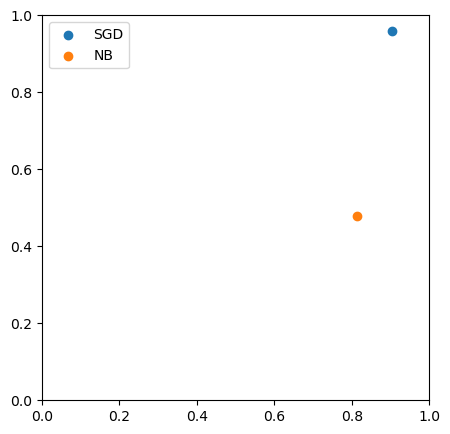

In [55]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

x = baseline_score['Accuracy']
y = baseline_score['Area under the ROC curve']

ax.set_xlim(0,1)
ax.set_ylim(0,1)

_=ax.scatter(x,y, label='SGD')
_=ax.scatter(x*0.9,y*0.5, label='NB')

ax.legend()

## Buscar outros modelos de classificadores

### Naive-Bayes

In [91]:
%%time
clf = BernoulliNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vectorizer__min_df": (1, 3, 5, 10),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vectorizer__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
gs.best_params_

CPU times: total: 19.1 s
Wall time: 5min 10s


{'clf__alpha': 0.1,
 'vectorizer__max_df': 0.6,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__norm': 'l1'}

In [85]:
clf = ComplementNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vectorizer__min_df": (1, 3, 5, 10),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vectorizer__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=10)
gs.fit(X_train, y_train)
gs.best_params_

{'clf__alpha': 1e-06}

In [ ]:
clf = MultinomialNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vectorizer__min_df": (1, 3, 5, 10),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vectorizer__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC')
gs.fit(X_train, y_train)
gs.best_params_

### kNN

### SGD

### Logistic Regression